In [1]:
from skimage import data, feature
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
import numpy as np
from astropy.convolution import convolve
from astropy.coordinates import SkyCoord
from astropy import wcs
from sklearn.cluster import KMeans
from skimage import data, feature
from scipy import optimize

In [2]:
def load(clustername):
    filename="/users/ksarmien/Documents/clusters_substructure/"+clustername+"/best_map.fits"
    mapD=get_pkg_data_filename(filename)
    hdu_map = fits.open(mapD)[0]
    img_map = hdu_map.data
    hdu_weight_map = fits.open(mapD)[1]
    temp=np.copy(img_map)
    weight_map = hdu_weight_map.data
    weight_map = weight_map/np.max(weight_map)
    temp[weight_map<0.2]=0
    #temp_max=np.max(temp)
    #temp_min=np.min(temp)
    temp=temp - np.min(temp)
    return temp

In [3]:
def load_actual(clustername):
    filename="/users/ksarmien/Documents/clusters_substructure/"+clustername+"/best_map.fits"
    mapD=get_pkg_data_filename(filename)
    hdu_map = fits.open(mapD)[0]
    img_map = hdu_map.data
    hdu_weight_map = fits.open(mapD)[1]
    temp=np.copy(img_map)
    weight_map = hdu_weight_map.data
    weight_map = weight_map/np.max(weight_map)
    temp[weight_map<0.2]=0
    return temp

In [4]:
def blobs(clustername,size):
    if size=="small":
        theta1=[2,3,4]
        theta2=[2,3,4]
    elif size=="medium":
        theta1=[30,35,40,45,50]
        theta2=[30,35,40,45,50]
    elif size=="large":
        theta1=[50,55,60,65,70]
        theta2=[50,55,60,65,70]
        
    #theta1=[10,15,20,25,30,35,40,45,50,55,60,65,70]
    #theta2=[10,15,20,25,30,35,40,45,50,55,60,65,70]
    blob_dict={}
    temp=load(clustername)
    for i in range(len(theta1)): 
        for j in range(len(theta2)):
            if theta2[j]>theta1[i]:
                blobs=feature.blob_dog(temp,theta1[i],theta2[j],threshold=4)
                x_coord = np.array(blobs[:,0],int)
                y_coord = np.array(blobs[:,1],int)
                #size = np.array(blobs[:,2])
                vals=temp[x_coord,y_coord]
                x_final=x_coord[vals>0.0]
                y_final=y_coord[vals>0.0]
                #size_final=size[vals>0.0]
                blob_dict[str(theta1[i])+"_"+str(theta2[j])]=[x_final,y_final]
    return blob_dict

In [5]:
def subtract_src(clustername):
    mapD=load_actual(clustername)
    copy=mapD.copy()
    copy2=mapD.copy()
    srcs = all_point_sources(clustername,"small")
    rad=20
    mi=10
    ma=rad*2-mi
    x_coords=np.arange(0,rad*2,1)
    y_coords=np.arange(0,rad*2,1)
    x_g,y_g=np.meshgrid(x_coords,y_coords)
    try:
        for i in range(len(srcs)):
            large_region_src=copy[int(srcs[i][0]-rad):int(srcs[i][0]+rad),int(srcs[i][1]-rad):int(srcs[i][1]+rad)]
            large_region_src[mi:ma,mi:ma]=0
            mean = np.mean(large_region_src)
            subtracted_background = copy2[int(srcs[i][0]-rad):int(srcs[i][0]+rad),int(srcs[i][1]-rad):int(srcs[i][1]+rad)]-np.mean(large_region_src)
            params=gaussianFit(subtracted_background,rad,rad)
            fit=twoDgaussian(params[0],params[1],params[2],params[3])
            model_fit=fit(x_g,y_g)
            mapD[int(srcs[i][0]-rad):int(srcs[i][0]+rad),int(srcs[i][1]-rad):int(srcs[i][1]+rad)]=mapD[int(srcs[i][0]-rad):int(srcs[i][0]+rad),int(srcs[i][1]-rad):int(srcs[i][1]+rad)]-model_fit
    except IndexError:
        mapD=mapD
    return(mapD)
    #for src in point_srcs:

In [6]:
def twoDgaussian(amplitude,center_x,center_y,std):
    return lambda x,y: amplitude*np.exp(-1*((center_x-x)**2+(center_y-y)**2)/(2*std**2))

In [7]:
def gaussianFit(img,center_x,center_y):
    amplitude = img.max()
    std = 4
    params = amplitude, center_x, center_y, 5
    errorfunction = lambda p: np.ravel(twoDgaussian(*p)(*np.indices(img.shape))-img)
    p, success = optimize.leastsq(errorfunction,params)
    return p 

In [8]:
def all_point_sources(clustername,size):
    blobs_dict = blobs(clustername,size)
    """"Takes in a dictionary of point sources (keys are names for each DoG map, values are the pixel location of point sources) and returns the kmeans centers (point source location in )"""
    X = [0,0]
    keys=list(blobs_dict.keys())
    src=[]
    for i in range(len(keys)):
        arr_1 = np.array(list(zip(blobs_dict[keys[i]][0],blobs_dict[keys[i]][1])))
        n_src=len(blobs_dict[keys[i]][0])
        src = np.append(src,n_src)
        if np.size(arr_1)==0:
            X=X
        else:
            X=np.vstack((X,arr_1))
    
    num_centers=np.mean(src)
    if np.sum(src)==0.0:
        point_src_centers=[]
    else:
        X=X[1:]
        point_src_centers=np.unique(X,axis=0)
        #kmeans= KMeans(n_clusters=num_centers,random_state=0).fit(X)
        #point_src_centers=kmeans.cluster_centers_
    ##############
    #w=get_WCS_from_fits(clustername)
    #coords_ra_dec=w.wcs_pix2world(point_src_centers,1)
    return point_src_centers #Point_src_diction,coords_ra_dec,point_src_centers

In [9]:
clusters_array=['moo0105','moo0135','moo1014','moo1031','moo1046','moo1052','moo1054','moo1059','moo1108','moo1110','moo1142','moo1203','moo1322','moo1329','moo1354','moo1506']

In [10]:
all_srcs_all_clusters_dict={}
all_maps={}
for i in clusters_array:
    all_maps[i]=load(i)
    srcs=all_point_sources(i,"small")
    all_srcs_all_clusters_dict[i]=srcs

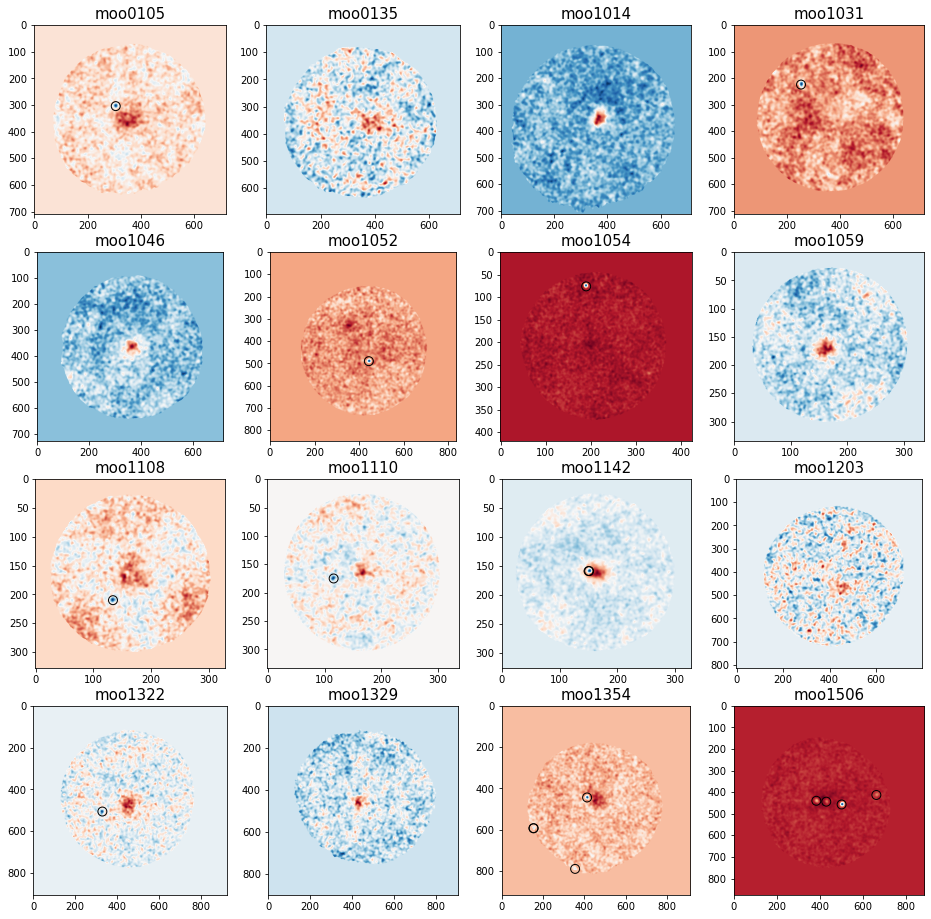

In [11]:
n=16
fig, axs = plt.subplots(int(n/4),4,figsize=(16,16))
count=0
for i in range(int(n/4)):
    for j in range(4):
        axs[i,j].imshow(all_maps[clusters_array[count]],cmap="RdBu")
        try:
            axs[i,j].scatter(all_srcs_all_clusters_dict[clusters_array[count]][:,1],all_srcs_all_clusters_dict[clusters_array[count]][:,0],s=80,color="none",edgecolor="black")
        except TypeError:
            axs[i,j].imshow(all_maps[clusters_array[count]],cmap="RdBu")
        axs[i,j].set_title(clusters_array[count],fontsize=15)
        count+=1
plt.savefig("psrcs_detection.jpeg")

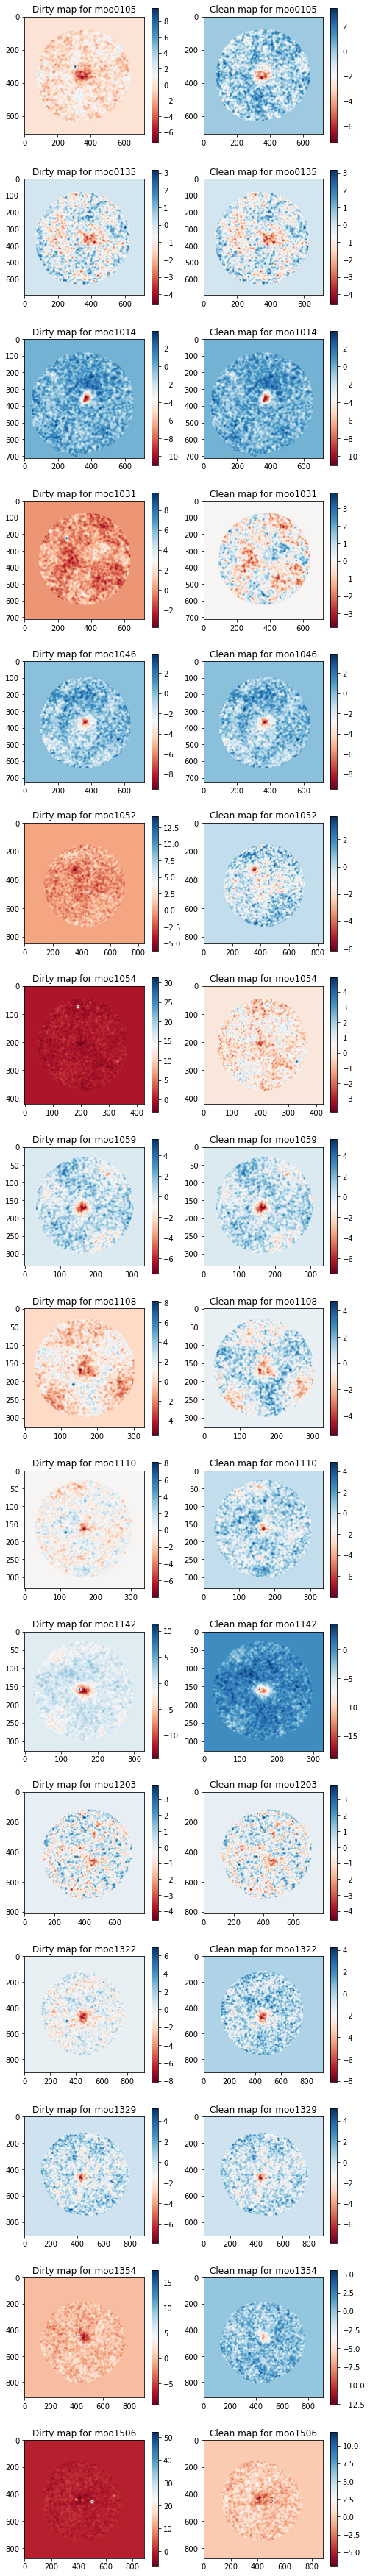

In [12]:
n=len(clusters_array)
fig, axs = plt.subplots(n,2,figsize=(8,16*4))
count=0
for i in range(n):
    map_dirty = load_actual(clusters_array[i])
    map_clean = subtract_src(clusters_array[i])
    axs[i,0].set_title("Dirty map for "+ clusters_array[i])
    im1=axs[i,0].imshow(map_dirty,cmap="RdBu")
    fig.colorbar(im1,ax=axs[i,0])
    axs[i,1].set_title("Clean map for "+ clusters_array[i])
    im2=axs[i,1].imshow(map_clean,cmap="RdBu")
    fig.colorbar(im2,ax=axs[i,1])
plt.savefig("dirty_clean_comparison.jpeg")
plt.show()       